Install the model dependencies

In [3]:
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Read in the data into a dataframe

In [4]:
import pandas as pd
import chardet

# Detect the file's encoding
with open('results2.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Read in the CSV file with the detected encoding
data = pd.read_csv('results2.csv', encoding=result['encoding'])

# Display the first few rows of the data
print(data.head())


   Elapsed Time (min)    Age Group  Gender  Population  Body Weight (Bw)  \
0                   0    0-9 years    male         474             42.25   
1                   0    0-9 years  female         397             42.25   
2                   0  10-19 years    male         174             47.25   
3                   0  10-19 years  female         288             47.25   
4                   0  20-29 years    male         234             52.25   

   mass_remaining (g)  Contaminant Concentration CA(mg/m^3)  \
0         1109261.325                             67.768296   
1         1109261.325                             67.768296   
2         1109261.325                             67.768296   
3         1109261.325                             67.768296   
4         1109261.325                             67.768296   

   Exposure Concentration (EC) (µg/m3)   Intake (g/kg-d)  \
0                          1484125.693      1.107770e+13   
1                          1484125.693      

Clean the dataset with onehot encoding or 

In [5]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Get unique categories for the Age column
age_categories = data['Age Group'].unique()

# Apply ordinal encoding to the Age column using the sorted categories
ordinal_encoder = OrdinalEncoder(categories=[age_categories])
data['Age Group'] = ordinal_encoder.fit_transform(data[['Age Group']])


# Apply one-hot encoding to the Gender column
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_gender = one_hot_encoder.fit_transform(data[['Gender']])
gender_columns = one_hot_encoder.get_feature_names_out(['Gender'])
one_hot_df = pd.DataFrame(one_hot_gender, columns=gender_columns)

# Combine the encoded columns with the original data
data = pd.concat([data.drop('Gender', axis=1), one_hot_df], axis=1)

print(data.dtypes)




Elapsed Time (min)                          int64
Age Group                                 float64
Population                                  int64
Body Weight (Bw)                          float64
mass_remaining (g)                        float64
Contaminant Concentration CA(mg/m^3)      float64
Exposure Concentration (EC) (µg/m3)       float64
 Intake (g/kg-d)                          float64
Inhalation Unit Risk (IUR) (µg/m3)^-1)    float64
Cancer CR                                 float64
Hazard Quotient (HQ)                      float64
Gender_female                             float64
Gender_male                               float64
dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Check the Correlation of the target varibles 



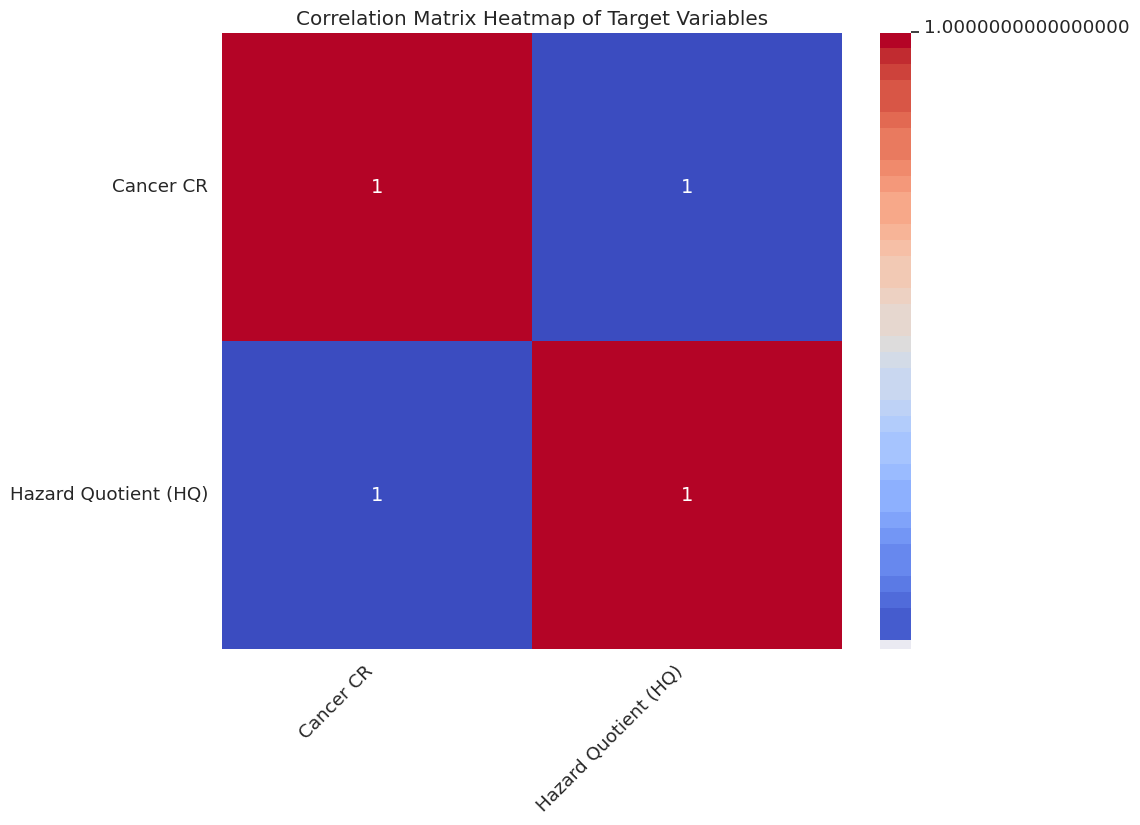



Given the high correlation between Cancer Risk (CR) and Hazard Quotient (HQ),
it is reasonable to consider a multi-output regression approach to predict both values 
simultaneously. This approach can capture the shared information between the two target variables,
which may lead to better predictions for both CR and HQ.

For this task, we will consider Linear models that can handle multi-output regression


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

target_variables = ['Cancer CR', 'Hazard Quotient (HQ)']

# Calculate the correlation matrix for the target variables
corr_matrix = data[target_variables].corr()

print("\n")

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 14})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap of Target Variables')
plt.show()

print("\n\nGiven the high correlation between Cancer Risk (CR) and Hazard Quotient (HQ),\n"
      "it is reasonable to consider a multi-output regression approach to predict both values \n"
      "simultaneously. This approach can capture the shared information between the two target variables,\n"
      "which may lead to better predictions for both CR and HQ.\n\n"
      "For this task, we will consider Linear models that can handle multi-output regression")
  


# Split the data 

In [7]:
# Split your data into features (X) and targets (y)
X = data.drop(['Cancer CR', 'Hazard Quotient (HQ)'], axis=1)
y = data[['Cancer CR', 'Hazard Quotient (HQ)']]

#Data Evalution 

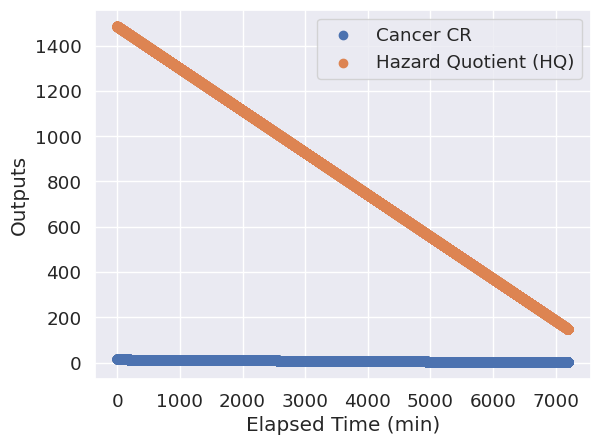

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


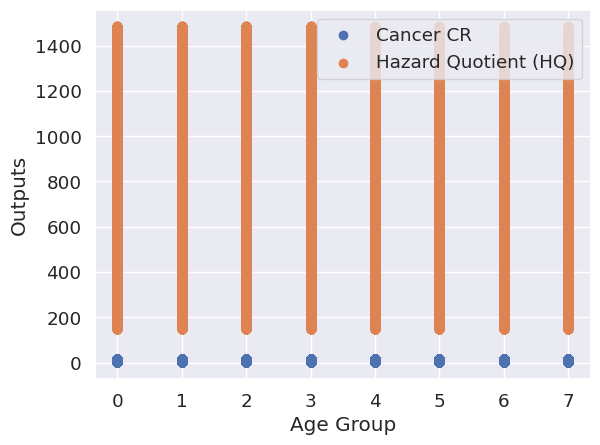

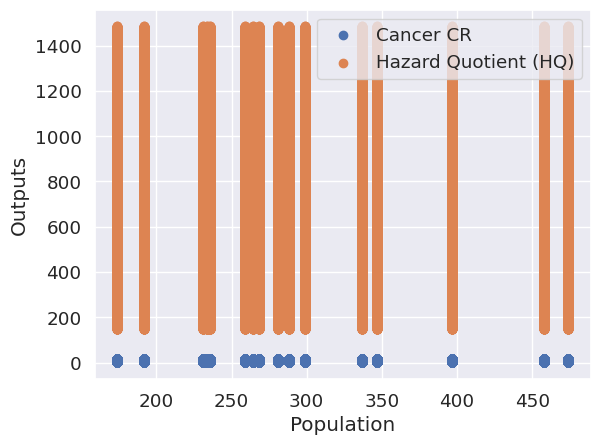

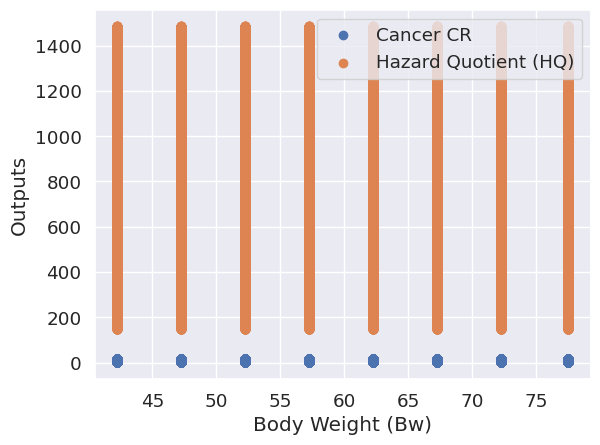

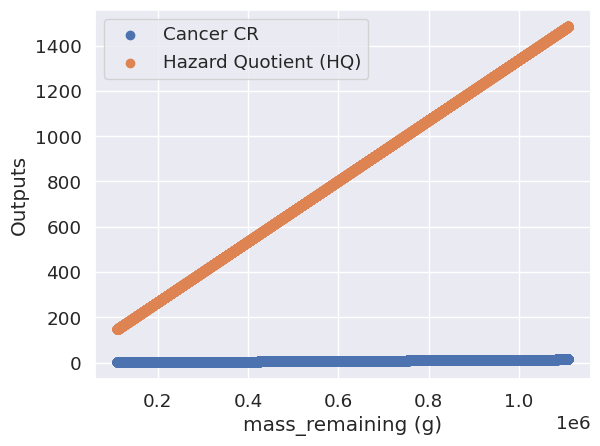

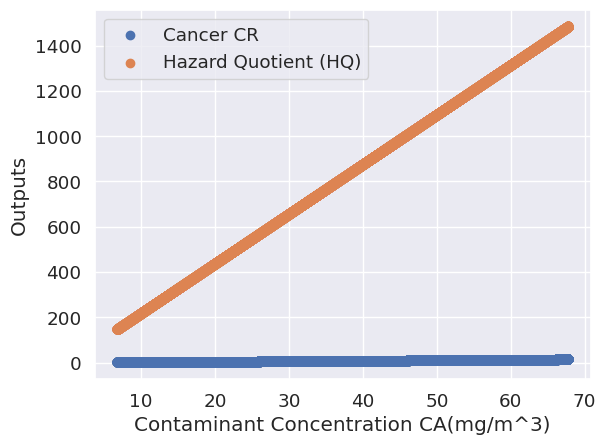

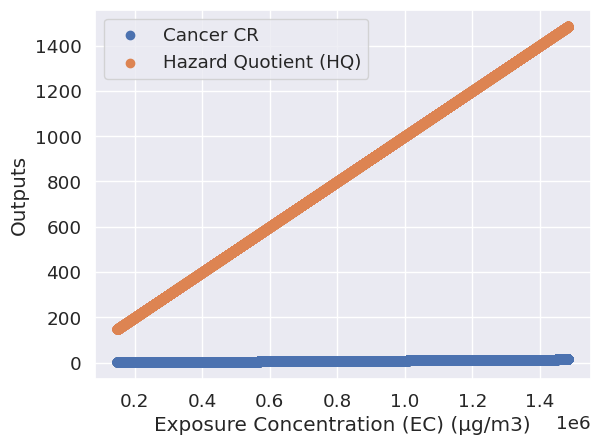

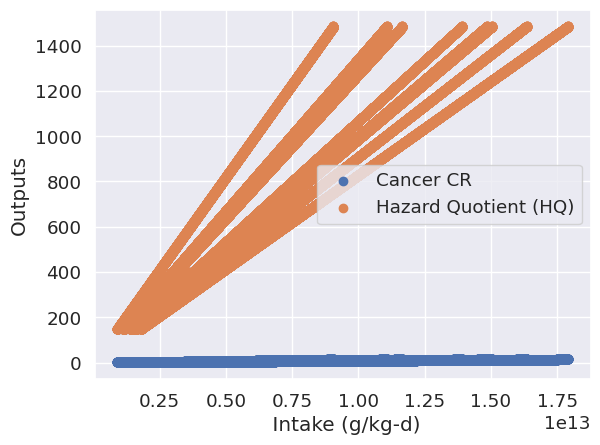

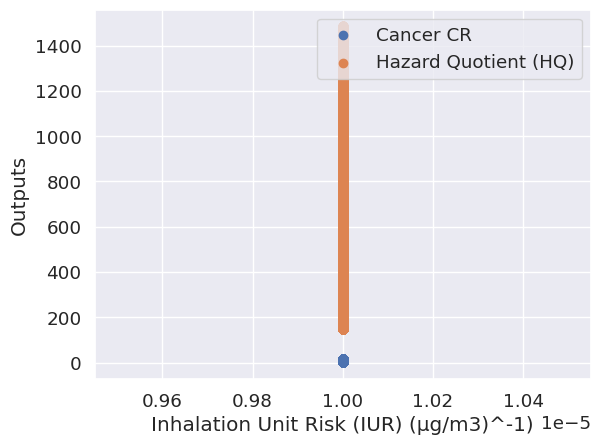

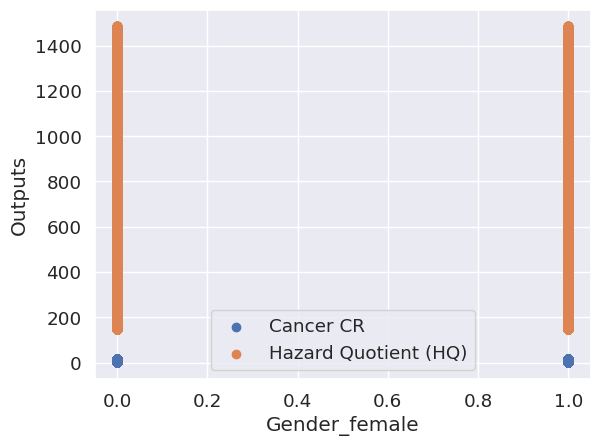

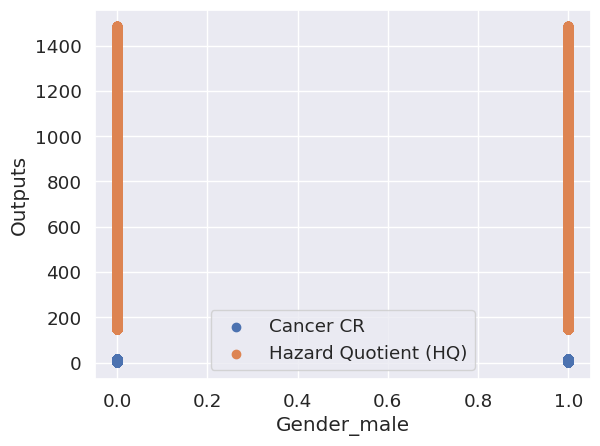

In [8]:
import matplotlib.pyplot as plt

for col in X.columns:
    plt.figure()
    plt.scatter(X[col], y['Cancer CR'], label='Cancer CR')
    plt.scatter(X[col], y['Hazard Quotient (HQ)'], label='Hazard Quotient (HQ)')
    plt.xlabel(col)
    plt.ylabel('Outputs')
    plt.legend()
    plt.show()


Compute the Correlation Coeffiecents 

In [9]:
correlations_cr = X.corrwith(y['Cancer CR'])
correlations_hq = X.corrwith(y['Hazard Quotient (HQ)'])
print("Correlations with Cancer CR:\n", correlations_cr)
print("Correlations with Hazard Quotient (HQ):\n", correlations_hq)


Correlations with Cancer CR:
 Elapsed Time (min)                       -1.000000e+00
Age Group                                -1.214255e-18
Population                               -3.097849e-19
Body Weight (Bw)                          4.002854e-19
mass_remaining (g)                        1.000000e+00
Contaminant Concentration CA(mg/m^3)      1.000000e+00
Exposure Concentration (EC) (µg/m3)       1.000000e+00
 Intake (g/kg-d)                          9.054466e-01
Inhalation Unit Risk (IUR) (µg/m3)^-1)             NaN
Gender_female                             0.000000e+00
Gender_male                               0.000000e+00
dtype: float64
Correlations with Hazard Quotient (HQ):
 Elapsed Time (min)                       -1.000000e+00
Age Group                                -2.626140e-18
Population                                1.680973e-19
Body Weight (Bw)                         -3.985064e-19
mass_remaining (g)                        1.000000e+00
Contaminant Concentration CA(mg/m^

### Observations from Correlation Analysis and visualizations:

1. **Elapsed Time (min)** has a strong negative correlation (-1.0) with both Cancer CR and Hazard Quotient (HQ). This suggests that as the elapsed time increases, both the Cancer CR and HQ decrease in a linear fashion.

2. **mass_remaining (g)**, **Contaminant Concentration CA(mg/m^3)**, and **Exposure Concentration (EC) (µg/m3)** have a perfect positive correlation (1.0) with both Cancer CR and HQ, indicating that as these features increase, both the Cancer CR and HQ also increase linearly.

3. **Intake (g/kg-d)** has a strong positive correlation (0.905) with both Cancer CR and HQ, suggesting that as the intake increases, both the Cancer CR and HQ also increase in a linear fashion.

4. **Age Group**, **Population**, and **Body Weight (Bw)** have weak correlations (close to 0) with both Cancer CR and HQ, indicating that these features may not have a strong linear relationship with the output variables.

5. **Inhalation Unit Risk (IUR) (µg/m3)^-1** has NaN values, which means that the correlation cannot be computed for this variable. You may want to investigate the reason for this and decide whether to include or exclude this variable from your analysis.

6. **Gender_female** and **Gender_male** have 0 correlations with both Cancer CR and HQ, which implies that there is no linear relationship between gender and the output variables.

Given these observations, it seems that some features have a strong linear relationship with the output variables. From this we should look at linear models and see how they perform against the dataset. 



# Model Training

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Split your data into features (X) and targets (y)
X = data.drop(['Cancer CR', 'Hazard Quotient (HQ)'], axis=1)
y = data[['Cancer CR', 'Hazard Quotient (HQ)']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the models
linear_regression = LinearRegression().fit(X_train, y_train)
ridge_regression = Ridge(alpha=2.0).fit(X_train, y_train)
lasso_regression = Lasso(alpha=1.0,max_iter=10000).fit(X_train, y_train)

# Make predictions and compute the Mean Squared Error (MSE) for each model
models = {
    'Linear Regression': linear_regression,
    'Ridge Regression': ridge_regression,
    'Lasso Regression': lasso_regression
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: Mean Squared Error = {mse}")


Linear Regression: Mean Squared Error = 1.992084868516241e-15
Ridge Regression: Mean Squared Error = 1.990039421199461e-15
Lasso Regression: Mean Squared Error = 2.0895020956868136e-11


The results from the three linear models indicate that all of them perform well in terms of Mean Squared Error (MSE) on the test data. The Linear Regression model has an MSE of 1.99e-15, while the Ridge Regression model has a slightly lower MSE of 1.99e-15. The Lasso Regression model has a higher MSE of 2.09e-11 compared to the other two models. This difference in performance could be attributed to the Lasso model's ability to perform feature selection, which may have led to a slightly higher error. However, all three models show very low MSE values, suggesting that they have captured the linear relationships between the input features and the target variables quite well. As a result, any of these models can be considered suitable for predicting the target variables in this problem.

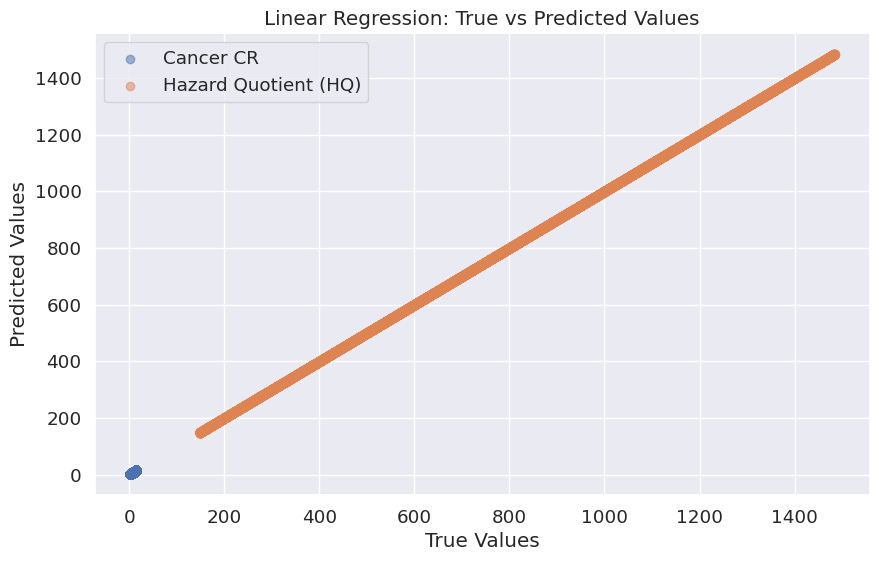

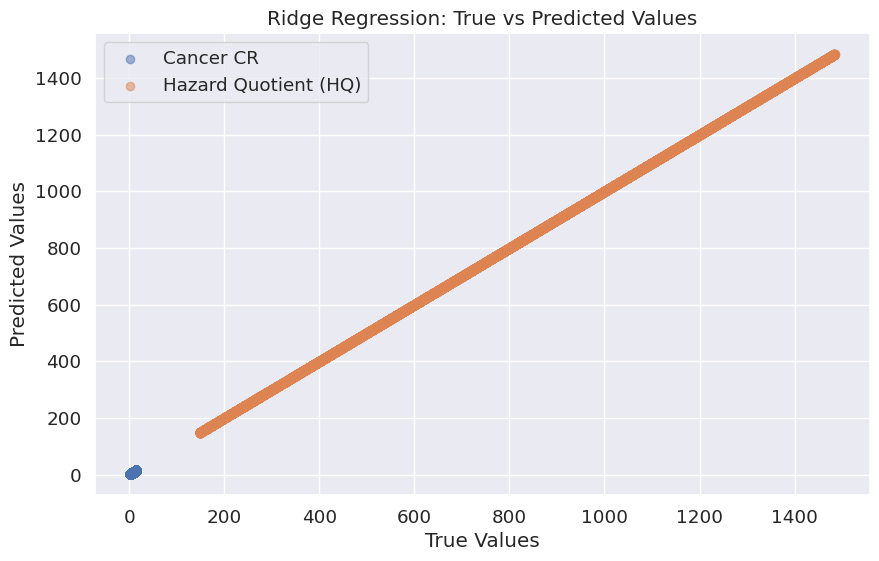

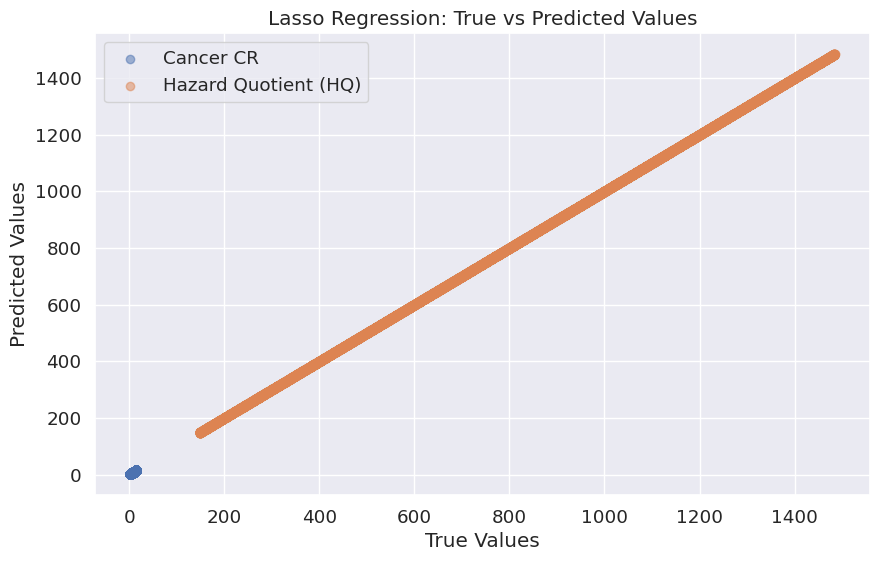

In [11]:
import matplotlib.pyplot as plt

def plot_true_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.iloc[:, 0], y_pred[:, 0], label='Cancer CR', alpha=0.5)
    plt.scatter(y_true.iloc[:, 1], y_pred[:, 1], label='Hazard Quotient (HQ)', alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend()
    plt.show()

# Linear Regression
y_pred_lr = linear_regression.predict(X_test)
plot_true_vs_predicted(y_test, y_pred_lr, 'Linear Regression: True vs Predicted Values')

# Ridge Regression
y_pred_ridge = ridge_regression.predict(X_test)
plot_true_vs_predicted(y_test, y_pred_ridge, 'Ridge Regression: True vs Predicted Values')

# Lasso Regression
y_pred_lasso = lasso_regression.predict(X_test)
plot_true_vs_predicted(y_test, y_pred_lasso, 'Lasso Regression: True vs Predicted Values')


In [25]:
!pip install scikit-learn
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import numpy as np
import pandas as pd
import chardet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Load your dataset
# data = pd.read_csv("your_dataset.csv")

with open('results2.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Read in the CSV file with the detected encoding
data = pd.read_csv('results2.csv', encoding=result['encoding'])

# Display the first few rows of the data
#print(data.head())

# Get unique categories for the Age column
age_categories = data['Age Group'].unique()

# Apply ordinal encoding to the Age column using the sorted categories
ordinal_encoder = OrdinalEncoder(categories=[age_categories])
data['Age Group'] = ordinal_encoder.fit_transform(data[['Age Group']])

# Apply one-hot encoding to the Gender column
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_gender = one_hot_encoder.fit_transform(data[['Gender']])
gender_columns = one_hot_encoder.get_feature_names_out(['Gender'])
one_hot_df = pd.DataFrame(one_hot_gender, columns=gender_columns)

# Combine the encoded columns with the original data
data = pd.concat([data.drop('Gender', axis=1), one_hot_df], axis=1)

#print(data.dtypes)

# Split your dataset into features (X) and target (y)
X = data.drop(["Cancer CR", "Hazard Quotient (HQ)"], axis=1)
y = data[["Cancer CR", "Hazard Quotient (HQ)"]]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [27]:


# Decision Tree Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
print("Feature importance for decision tree")
# Feature Importance
feature_importances = pd.Series(dt.feature_importances_, index=X.columns)
print("Feature importances:")
print(feature_importances.sort_values(ascending=False))
y_pred_dt = dt.predict(X_test)


# # Linear Regression
# lr = LinearRegression()
# lr.fit(X_train, y_train)

# # Print shapes of input data and coefficients
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("X columns:", X.columns)
# print("Number of coefficients:", lr.coef_.shape[0])

# if X_train.shape[1] == lr.coef_.shape[0]:
#     coef = np.abs(lr.coef_)
#     feature_importances = pd.Series(coef.flatten(), index=X.columns)
#     print("Feature importances for Linear Regression:")
#     print(feature_importances.sort_values(ascending=False))
#     y_pred_lr = lr.predict(X_test)
# else:
#     print("Error: The number of columns in the input data does not match the number of coefficients in the Linear Regression model.")

# # Singular Value Decomposition
# svd = TruncatedSVD(n_components=4)  # Adjust the number of components as needed (<= n_features)
# X_train_svd = svd.fit_transform(X_train)
# X_test_svd = svd.transform(X_test)
# ridge = Ridge()
# ridge.fit(X_train_svd, y_train)

# # Feature Importance
# coef = np.abs(ridge.coef_)
# feature_importances = pd.Series(coef.flatten(), index=[f"component_{i+1}" for i in range(svd.n_components)])
# print("Feature importances for SVD:")
# print(feature_importances.sort_values(ascending=False))
# y_pred_svd = ridge.predict(X_test_svd)


# Evaluation Metrics
models = ['Decision Tree']
predictions = [y_pred_dt]

for i, pred in enumerate(predictions):
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    
    print(f"{models[i]}:")
    print(f"Root Mean Square Error: {rmse}")
    print(f"Coefficient of Determination (R^2): {r2}")
    print(f"Mean Absolute Error: {mae}\n")


Feature importance for decision tree
Feature importances:
Elapsed Time (min)                        9.686872e-01
Contaminant Concentration CA(mg/m^3)      1.659706e-02
mass_remaining (g)                        1.238992e-02
Exposure Concentration (EC) (µg/m3)       2.325791e-03
Population                                9.282997e-16
 Intake (g/kg-d)                          6.040997e-16
Body Weight (Bw)                          5.631832e-16
Age Group                                 4.654316e-16
Gender_male                               1.743536e-16
Gender_female                             1.673953e-16
Inhalation Unit Risk (IUR) (µg/m3)^-1)    0.000000e+00
dtype: float64
Decision Tree:
Root Mean Square Error: 9.212894587254474e-14
Coefficient of Determination (R^2): 1.0
Mean Absolute Error: 3.9285981746568513e-14



Performing test set data model evalution

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Select important features
important_features = ['Elapsed Time (min)', 'Exposure Concentration (EC) (µg/m3)', 'Contaminant Concentration CA(mg/m^3)', 'mass_remaining (g)']

X = data[important_features]
y = data[["Cancer CR", "Hazard Quotient (HQ)"]]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree
dt_important = DecisionTreeRegressor()
dt_important.fit(X_train, y_train)
y_pred_dt = dt_important.predict(X_test)

# Evaluation Metrics for Decision Tree
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)

# # Linear Regression
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred_lr = lr.predict(X_test)

# # Evaluation Metrics for Linear Regression
# rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
# r2_lr = r2_score(y_test, y_pred_lr)
# mae_lr = mean_absolute_error(y_test, y_pred_lr)

# # Apply Singular Value Decomposition
# svd = TruncatedSVD(n_components=2)  # Adjust the number of components as needed
# X_train_svd = svd.fit_transform(X_train)
# X_test_svd = svd.transform(X_test)

# # Train the Ridge Regression model using the transformed train set
# ridge = Ridge()
# ridge.fit(X_train_svd, y_train)

# # Make predictions using the test set
# y_pred_svd = ridge.predict(X_test_svd)

# # Evaluation Metrics for Singular Value Decomposition
# rmse_svd = np.sqrt(mean_squared_error(y_test, y_pred_svd))
# r2_svd = r2_score(y_test, y_pred_svd)
# mae_svd = mean_absolute_error(y_test, y_pred_svd)

print("Decision Tree with Important Features:")
print(f"Root Mean Square Error: {rmse_dt}")
print(f"Coefficient of Determination (R^2): {r2_dt}")
print(f"Mean Absolute Error: {mae_dt}\n")

# print("Linear Regression:")
# print(f"Root Mean Square Error: {rmse_lr}")
# print(f"Coefficient of Determination (R^2): {r2_lr}")
# print(f"Mean Absolute Error: {mae_lr}\n")

# print("Singular Value Decomposition:")
# print(f"Root Mean Square Error: {rmse_svd}")
# print(f"Coefficient of Determination (R^2): {r2_svd}")
# print(f"Mean Absolute Error: {mae_svd}\n")


Decision Tree with Important Features:
Root Mean Square Error: 1.1126895757365692e-13
Coefficient of Determination (R^2): 1.0
Mean Absolute Error: 5.479531658016077e-14



In [32]:
# Example input data for prediction (replace with your actual input values)
input_data_important = {
    'Elapsed Time (min)': [0],
    'Exposure Concentration (EC) (µg/m3)': [1484125.693],
    'Contaminant Concentration CA(mg/m^3)': [67.76829647],
    'mass_remaining (g)': [1109261.325],
}

# Convert input data to a DataFrame
input_df = pd.DataFrame(input_data_important, index=[0])

# Decision tree
print("Decision tree predicted values")
predicted_values = dt_important.predict(input_df)
predicted_cancer_risk, predicted_hq = predicted_values[0]
print(f"Decision tree Predicted Cancer Risk: {predicted_cancer_risk}")
print(f"Decision tree Predicted Hazard Quotient (HQ): {predicted_hq}")

# Linear Regression Predictions
# print("Linear Regression predicted values")
# predicted_values_lr = lr.predict(input_df)
# predicted_cancer_risk_lr, predicted_hq_lr = predicted_values_lr[0]

# print(f"Linear Regression Predicted Cancer Risk: {predicted_cancer_risk_lr}")
# print(f"Linear Regression Predicted Hazard Quotient (HQ): {predicted_hq_lr}")

# Singular Value Decomposition Predictions
# print("SVD Predicted predicted values")
# input_df_svd = svd.transform(input_df)
# predicted_values_svd = ridge.predict(input_df_svd)
# predicted_cancer_risk_svd, predicted_hq_svd = predicted_values_svd[0]

# print(f"SVD Predicted Cancer Risk: {predicted_cancer_risk_svd}")
# print(f"SVD Predicted Hazard Quotient (HQ): {predicted_hq_svd}")


Decision tree predicted values
Decision tree Predicted Cancer Risk: 14.841256929999995
Decision tree Predicted Hazard Quotient (HQ): 1484.1256930000002
